# Histopathologic Cancer Detection

In this project i participate in the Histopathologic Cancer Detection challenge on Kaggle. It's a is a binary image classification challenge. The goal is to predict whether a given image from scan contains cancer or not.

## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import glob

2025-04-21 16:32:43.956368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 16:32:43.963835: I external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:469] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
I0000 00:00:1745245963.971588   33360 cuda_dnn.cc:8703] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
I0000 00:00:1745245963.974132   33360 cuda_blas.cc:1413] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745245963.980346   33360 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Loading and Inspection

The dataset is https://www.kaggle.com/competitions/histopathologic-cancer-detection/data. The dataset is given in a CSV labels csv and TIF image format.

In [ ]:
df = pd.read_csv("data/train_labels.csv")

print("Shape of train_labels.csv:", df.shape)
df.head()

## Exploratory Data Analysis
Let's investigate the distribution of labels, if there's any missing or duplicate values and lets look at some examples of the images in the dataset.

label
0    130908
1     89117
Name: count, dtype: int64


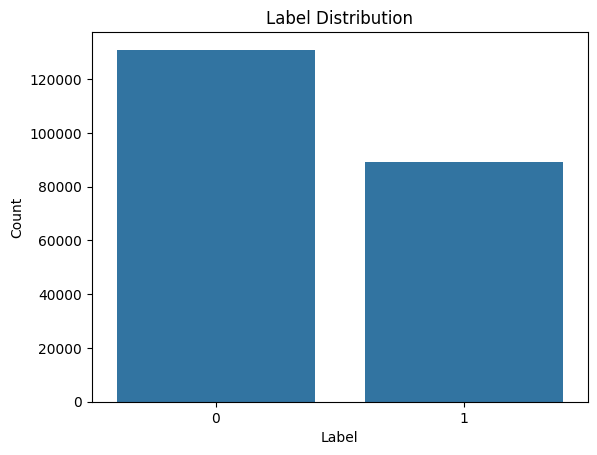

In [27]:
class_counts = df['label'].value_counts()
print(class_counts)

sns.countplot(data=df, x='label')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

There's a lot more healthy examples, than unhealthy in the dataset.

Let's have a look if the dataset is complete.

In [5]:
duplicates = df.duplicated(subset='id').sum()
print("Duplicate image IDs:", duplicates)
print("Missing values:\n", df.isnull().sum())

Duplicate image IDs: 0
Missing values:
 id       0
label    0
dtype: int64


The dataset being complete without duplicates, means i don't have to process the dataset further.

Cancer examples:


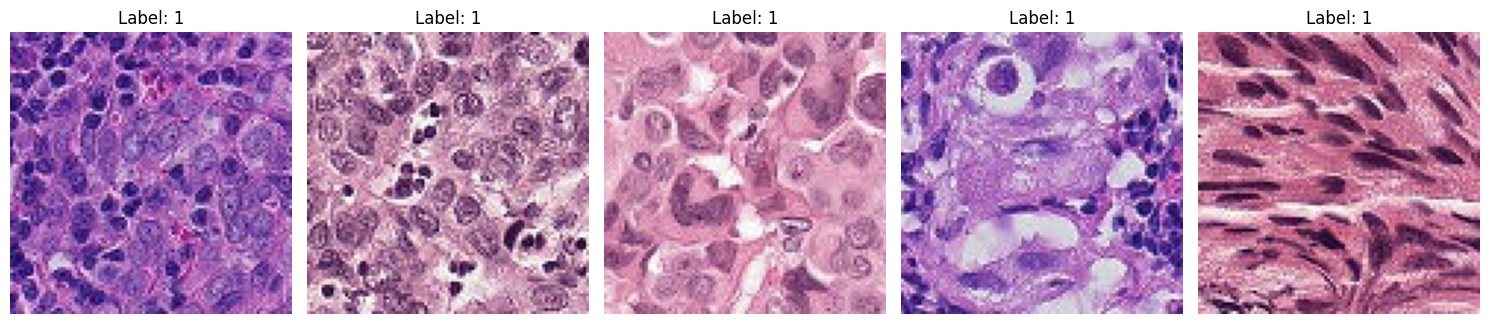

Healthy examples:


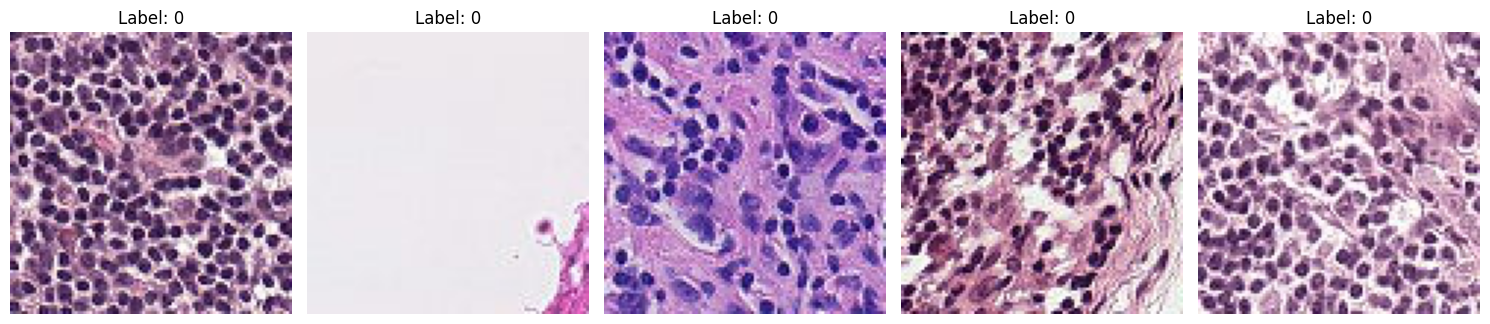

In [28]:
def show_images(label, n=5):
    sample = df[df['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, (idx, row) in enumerate(sample.iterrows()):
        path = f"data/train/{row['id']}.tif"
        img = Image.open(path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Label: {label}")
    plt.tight_layout()
    plt.show()

print("Cancer examples:")
show_images(1)

print("Healthy examples:")
show_images(0)

By eye, i wouldn't be able to say what makes an image label 1 or 0. So i wonder how well this will go.

## Model Building

Let's split the dataset into a training and validation data set.

In [ ]:
IMG_SIZE = 96
def load_images(df_subset):
    images = []
    for img_id in df_subset['id']:
        path = f"data/train/{img_id}.tif"
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

df_small = df.sample(5000, random_state=42)
X = load_images(df_small)
y = df_small['label'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

### Model Architecture

I kept the model pretty simple. Starting with a couple of convolutional layers layers to look for patterns in the image. Then a dense layer to reduce the shape and then a dropout layer, which should help avoid overfitting on the training data.

In [ ]:
test_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
test_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

test_model.summary()

/home/gnu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

Let's do a test fit, to see if everything works out alright.

In [ ]:
test_result = test_model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5957 - loss: 0.7852 - val_accuracy: 0.7720 - val_loss: 0.5768
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.5301 - val_accuracy: 0.7820 - val_loss: 0.5079
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7794 - loss: 0.4956 - val_accuracy: 0.7880 - val_loss: 0.4834
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8117 - loss: 0.4346 - val_accuracy: 0.7690 - val_loss: 0.4905
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8413 - loss: 0.3966 - val_accuracy: 0.7820 - val_loss: 0.4994
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8595 - loss: 0.3473 - val_accuracy: 0.7660 - val_loss: 0.5697
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8756 - loss: 0.2999 - val_accuracy: 0.7710 - val_loss: 0.5549
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8982 - loss: 0.2615 - val_accuracy: 0.

It's time to tune hyperparameters. Specifically the learning and dropout rate. I have a added a callback to save the best epoch of the best model.

In [ ]:
def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            MaxPooling2D(2, 2),
            
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return model

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)
datagen.fit(X_train)

param_grid = [
    {"learning_rate": 0.0005, "dropout_rate": 0.3},
    {"learning_rate": 0.0001, "dropout_rate": 0.4},
    {"learning_rate": 0.001, "dropout_rate": 0.5}
]
results = []

for i, params in enumerate(param_grid):
    print("")
    print(f"Training model {i+1}/{len(param_grid)}")
    print("Params:", params)
    
    model = build_model(learning_rate=params["learning_rate"],
                        dropout_rate=params["dropout_rate"])
    
    history = model.fit(
        datagen.flow(X_train, y_train),
        epochs=30,
        validation_data=(X_val, y_val),
        batch_size=32,
        callbacks=[ModelCheckpoint("best_model.keras", save_best_only=True)]
    )
    
    val_acc = max(history.history['val_accuracy'])
    results.append({**params, "val_accuracy": val_acc})
    print("Validation accuracy:", val_acc)


--- Training model 1/3 ---
Params: {'learning_rate': 0.0005, 'dropout_rate': 0.3}
Epoch 1/30


/home/gnu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/gnu/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6506 - loss: 0.6510 - val_accuracy: 0.7490 - val_loss: 0.5877
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7569 - loss: 0.5171 - val_accuracy: 0.7230 - val_loss: 0.6082
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7865 - loss: 0.4730 - val_accuracy: 0.7620 - val_loss: 0.5236
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7801 - loss: 0.4812 - val_accuracy: 0.7600 - val_loss: 0.5175
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7913 - loss: 0.4681 - val_accuracy: 0.7390 - val_loss: 0.6214
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8030 - loss: 0.4354 - val_accuracy: 0.7360 - val_loss: 0.6332
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7986 - loss: 0.4496 - val_accuracy: 0.7090 - val_loss: 0.5926
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7951 - loss: 0.4417 - val_accuracy: 0.755

In [15]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="val_accuracy", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df


,learning_rate,dropout_rate,val_accuracy
0,0.0005,0.3,0.812
1,0.0010,0.5,0.797
2,0.0001,0.4,0.769


## Step 4: Results and Analysis

Let's have a look at the best models accuracy and loss.

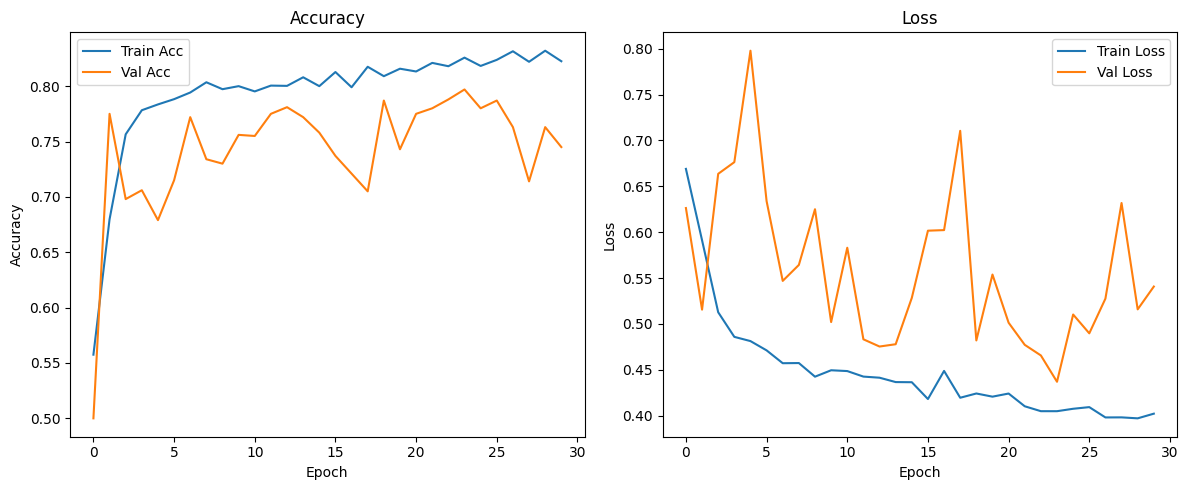

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Accuracy
While the accuracy of the training data increased, the validation accuracy flucuates between 70% and 79%, with an increase of minimum accuracy throughout the epochs.

### Loss
A similar thing happens to the loss over the epochs. Training loss consistantly reduces and the validation loss flucuates, but it shows a linear decent of the peak loss.

Both these findings indicate that futher training on more epochs, might have resulted in even better performance.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


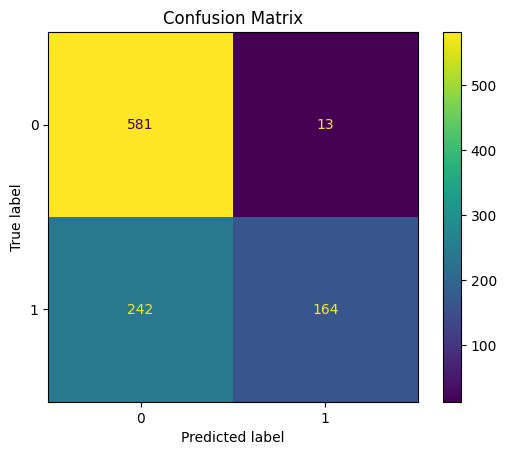

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       594
           1       0.93      0.40      0.56       406

    accuracy                           0.74      1000
   macro avg       0.82      0.69      0.69      1000
weighted avg       0.80      0.74      0.72      1000



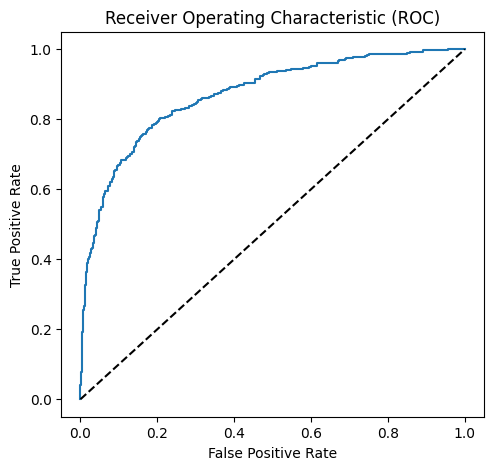

<Figure size 640x480 with 0 Axes>

In [ ]:
y_pred_probs = model.predict(X_val).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, y_pred))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], "k--", label="Random baseline")
plt.title(f"Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


Looking at the confusion matrix, the model does a great job at identifying healthy images, but it struggles more with detecting cance. It correctly predicts most healthy cases, but misses a large chunk of the cancerous ones — 242 of them got classified as healthy.

The ROC curve looks pretty good overall. There's a solid curve up toward the top-left corner, which means the model is generally good at ranking predictions, even if it doesn’t always choose the right threshold.

Precision for cancer is high (0.93), meaning when the model predicts an image to be an image of cancer, it's usually right. However recall is only 0.40, meaning accidentially classifies cancer images as healthy images.
The model favors caution, it only better at saying something is healthy than catching all the bad cases. Improving recall for cancer images would be the next big step, if i would do it again. Maybe more data, different model architecture, or tweaking hyperparameters more could help with that.

### Submission

Preparing the submission.csv, loading every image in the dataset and gather my predictions in a CSV file.

In [ ]:
test_files = glob.glob("data/test/*.tif")
test_ids = [os.path.basename(p).replace('.tif', '') for p in test_files]

X_test = []
for path in test_files:
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0
    X_test.append(img)

X_test = np.array(X_test)

y_test_probs = model.predict(X_test).flatten()
y_test_preds = (y_test_probs > 0.5).astype(int)

submission_df = pd.DataFrame({
    "id": test_ids,
    "label": y_test_preds
})
submission_df.to_csv("submission.csv", index=False)

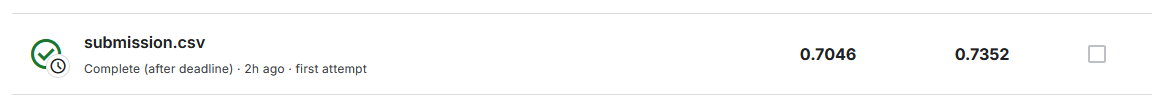

## Conclusion

The model learned to recognize healthy images quite well, but it struggled more with spotting cancer. It was very precise when it did say "cancer," but it often missed them. That was seen by it's low recall score and the confusion matrix.
The ROC curve suggests the model actually ranks predictions decently, so maybe tweaking the threshold or the loss weighting could’ve helped recall. The accuracy hovered around 70–79% on validation, which aligns with with the 70.46% public and 73.52% private score i got on Kaggle.

The model didn’t really overfit, which i assume was because of the dropout layer. If I were to do this again, I’d try going deeper into hyperparameter tuning or maybe use a different architecture.